In [34]:
from sklearn.linear_model import SGDClassifier
import numpy as np
import collections
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy.special import logsumexp
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import geometry
import itertools
from collections import defaultdict
import collections
import target
import controler
import utils
from functools import reduce
import linear_regression
from multiprocessing import Pool
from functools import partial
import numpy as np
import geometry
import itertools 
from itertools import islice
import games
import feedexp3
import geometry_v2

def evaluate_parallel(nbCores, n_folds, horizon, alg, game):
    print("nbCores:", nbCores, "nbFolds:", n_folds, "Horizon:", horizon)
    pool = Pool(processes = nbCores) 
    task = Evaluation(horizon)
    return np.asarray(  pool.map( partial( task.eval_policy_once, alg, game ), range(n_folds) ) ) 

def runif_in_simplex(n):
  ''' Return uniformly random vector in the n-simplex '''
  k = np.random.exponential(scale=1.0, size=n)
  return k / sum(k)

class Evaluation:

    def __init__(self, horizon ):

        self.horizon = horizon
        # self.outcome_distribution = outcome_distribution
    
    def get_outcomes(self, game, job_id):
        np.random.seed(job_id)
        # self.means = runif_in_simplex( self.game.n_outcomes )
        outcomes = np.random.choice( game.n_outcomes , p= list( game.outcome_dist.values() ), size= self.horizon) 
        return outcomes

    def get_feedback(self, game, action, outcome):
        return game.FeedbackMatrix[ action ][ outcome ]

    def eval_policy_once(self, alg, game, jobid):

        action_counter = np.zeros( (game.n_actions, self.horizon) )

        # generate outcomes obliviously
        outcomes = self.get_outcomes(game, jobid)

        for t in range(self.horizon):

            # policy chooses one action
            action = alg.get_action(t)

            # Environment chooses one outcome
            outcome = outcomes[t]
            feedback =  self.get_feedback( game, action, outcome )

            alg.update(  action, feedback)
            # print('outcome', outcome, 'action',action, 'eta', alg.eta, 'gamma', alg.gamma, 'pbt',alg.pbt, 'pbt_hat', alg.pbt_hat)

            # policy suffers loss and regret
            # cumAllLosses += game.LossMatrix[...,outcome]
            # cumSufferedLoss += game.LossMatrix[action,outcome]
            # cumRegret[t] = cumSufferedLoss - min(cumAllLosses)
            for i in range(game.n_actions):
                if i == action:
                    action_counter[i][t] = action_counter[i][t-1] +1
                else:
                    action_counter[i][t] = action_counter[i][t-1]

        return action_counter

def eval_cpbvanilla_parallel(task, nbCores, n_folds, horizon, alpha):
    print("nbCores:", nbCores, "nbFolds:", n_folds, "Horizon:", horizon)
    pool = Pool(processes = nbCores) 
    return np.asarray(  pool.map( partial( task.cpb_vanilla_v2 ,alpha ), range(n_folds) ) ) 

def runif_in_simplex(n):
  ''' Return uniformly random vector in the n-simplex '''

  k = np.random.exponential(scale=1.0, size=n)
  return k / sum(k)

class SyntheticCase:

    def __init__(self, LossMatrix, FeedbackMatrix, horizon, outcome_dist ):
 
        self.LossMatrix = LossMatrix 
        self.FeedbackMatrix = FeedbackMatrix 
        
        self.outcome_dist = outcome_dist
        self.i_star = self.optimal_action( )
        
        self.horizon = horizon
        self.n_actions = len(self.LossMatrix)
        self.n_outcomes = len(self.LossMatrix[0])

    def optimal_action(self, ):
        deltas = []
        for i in range(len(self.LossMatrix)):
            deltas.append( self.LossMatrix[i,...].T @ list( self.outcome_dist.values() ) )
        return np.argmin(deltas)

    def delta(self,action):
        return ( self.LossMatrix[action,...] - self.LossMatrix[self.i_star,...] ).T @ list( self.outcome_dist.values() ) 

    def set_outcomes(self, job_id):
        np.random.seed(job_id)
        #self.means = runif_in_simplex( len( LossMatrix[0] ) )
        self.outcomes = np.random.choice( self.n_outcomes , p= list( self.outcome_dist.values() ), size= self.horizon) 

    def get_feedback(self, FeedbackMatrix, action, outcome):
        return FeedbackMatrix[ action ][ outcome ] 

    def W(self, mathcal_N, N_bar, observer_vector ):
        N = len(N_bar)
        W = np.zeros( N )
        for pair in mathcal_N:
            for k in range(N):
                value = np.fabs( observer_vector[ pair[0] ][ pair[1] ][k] ).max()
                #print(value)
                W[k] = max( W[k], value  )
        return W

    def cpb_vanilla_v2(self, job_id):
        import geometry_v3

        action_counter = np.zeros( (self.n_actions, self.horizon) )

        self.set_outcomes(job_id)

        N = self.n_actions
        M = self.n_outcomes
        A = geometry_v3.alphabet_size(self.FeedbackMatrix, N,M)
        print('n-actions', N, 'n-outcomes', M, 'alphabet', A)

        SignalMatrices = geometry_v3.calculate_signal_matrices(self.FeedbackMatrix, N,M,A)

        n = np.zeros(N)
        nu = [  np.zeros( A ) for i in range(N)] 

        pareto_actions = geometry_v3.getParetoOptimalActions(self.LossMatrix, N, M, [])
        neighborhood_actions = geometry_v3.getNeighborhoodActions(self.LossMatrix, N, M, [])
        # print('neighborhood_actions', neighborhood_actions)

        v =  geometry_v3.getV(self.LossMatrix, N, M, A, SignalMatrices, neighborhood_actions)
        # print('V', v)
        W = geometry_v3.getConfidenceWidth(neighborhood_actions, v, N);
        print(W)
        alpha = 1.01

        eta = []
        for i in range(N):
            eta.append( W[i]**2/3 )

        for t in range(self.horizon):
          
          if(t<N):

            action = t
            feedback = FeedbackMatrix[action][ self.outcomes[t]  ]
            n[action] += 1
            nu[action][ feedback ] += 1

            for i in range(N):
                if i == action:
                    action_counter[i][t] = action_counter[i][t-1] +1
                else:
                    action_counter[i][t] = action_counter[i][t-1]

          else: 

            halfspace = []

            for pair in neighborhood_actions:
                tdelta = 0
                c = 0
                for k in range(N):
                    tdelta += v[pair[0]][pair[1]][k].dot( nu[k] ) / n[k];
                    c += np.linalg.norm( v[pair[0]][pair[1]][k], np.inf ) * np.sqrt( alpha * np.log(t) / n[k]  )
                
                if( abs(tdelta) >= c):
                    halfspace.append( ( pair, np.sign(tdelta) ) )
                else:
                    halfspace.append( ( pair, 0 ) )
                # print('pair', pair,  'tdelta', tdelta, 'c', c)

            # print('halfspace')
            P_t = geometry_v3.getParetoOptimalActions(LossMatrix, N, M, halfspace)
            N_t = geometry_v3.getNeighborhoodActions(LossMatrix, N, M, halfspace)

            Nplus_t = []

            for pair in N_t:
              Nplus_t.append(pair[0])
              Nplus_t.append(pair[1])
              
            R_t = []
            for k in range(N):
              if n[k] <=  eta[k] * geometry_v3.f(t, alpha) :
                R_t.append(k)
            R_t = np.unique(R_t)

            # print('N_t', N_t, 'Nplus_t', Nplus_t,'R_t',R_t, 'P_t', P_t )

            union1= np.union1d( Nplus_t, P_t )
            union1 = np.array(union1, dtype=int)
            # print('union1', union1)
            S =  np.union1d(  union1  ,  R_t)
            S = np.array( S, dtype = int)
            # print('S', S)
            S = np.unique(S)
              
            istar=-1
            vmax = - 100000
            for i in S:
              value = W[i]**2/n[i]
              if value > vmax:
                istar = i

            if(istar == -1):
              print( "Error: no possible optimal action found (in cbp)" )

            feedback = FeedbackMatrix[action][ self.outcomes[t] ]
            n[action] += 1
            nu[action][ feedback ] += 1

            for i in range(N):
                if i == action:
                    action_counter[i][t] = action_counter[i][t-1] +1
                else:
                    action_counter[i][t] = action_counter[i][t-1]

        return action_counter

In [35]:
n_cores = 16
horizon = 50
n_folds = 25


for _ in range(10):
    # LossMatrix = np.array( [ [1, 0], [0, 1] ] )
    # FeedbackMatrix =  np.array([ [1, 1],[1, 0] ])
    LossMatrix = np.array( [ [1, 1, 0],[0, 1, 1], [1, 0, 1] ] )
    FeedbackMatrix = np.array( [ [1, 0, 0],[0, 1, 0], [0, 0, 1] ] )
    outcome_distribution = {'spam':0.2,'ham':0.6,'other':0.2}

    task = SyntheticCase(LossMatrix, FeedbackMatrix, horizon, outcome_distribution) 
    result = task.cpb_vanilla_v2(  1)  

    print( result )
    print()
    
# regret = np.cumsum( np.array( [ task.delta(i) for i in range(2) ] ).T @ result )
# plt.plot(regret)

# game = games.apple_tasting(False, outcome_distribution)
# regret= np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ result
# plt.plot(   regret , label = 'Bianchi', color = 'green' )

# result =  eval_feedexp_parallel(task, n_cores, n_folds, horizon, True, 'Piccolboni' ) 
# plt.plot(  np.mean( result , 0 ) , label = 'Piccolboni', color = 'green' )

# result =  eval_feedexp_parallel(task, n_cores, n_folds, horizon, True, 'Bianchi' ) 
# plt.plot(  np.mean( result , 0 ) , label = 'Bianchi', color = 'orange' )

# plt.legend()

n-actions 3 n-outcomes 3 alphabet 2
[0.5 0.5 0.5]
[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 0.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
  17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34.
  35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48.]]

n-actions 3 n-outcomes 3 alphabet 2
[0.5 0.5 0.5]
[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. 

In [6]:
n_cores = 16
n_folds = 100
horizon = 2000

outcome_distribution =  {'spam':0.05,'ham':0.95}

nbCores: 16 nbFolds: 100 Horizon: 2000
nbCores: 16 nbFolds: 100 Horizon: 2000


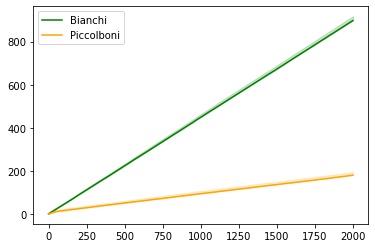

In [7]:
import feedexp3_v2
game = games.apple_tasting(False, outcome_distribution)

alg = feedexp3_v2.FeedExp3(  game, horizon, 'Bianchi',)
task = Evaluation(horizon)
task.eval_policy_once(alg,game,10)
result1 = evaluate_parallel(n_cores, n_folds, horizon, alg, game)
regret1 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.mean(result1,0) 
std1 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.std(result1,0) 
plt.plot(   regret1 , label = 'Bianchi', color = 'green' )
plt.fill_between( range(horizon) ,  regret1    , regret1 + std1 , color = 'green' , alpha = 0.2)

alg = feedexp3.FeedExp3(  game, horizon, 'Piccolboni',)
result2 = evaluate_parallel(n_cores, n_folds, horizon, alg, game)
regret2 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.mean(result2,0) 
std2 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.std(result2,0) 
plt.plot(   regret2  , label = 'Piccolboni', color = 'orange' )
plt.fill_between( range(horizon) ,  regret2    , regret2 + std2 , color = 'orange' , alpha = 0.2)

plt.legend()


nbCores: 16 nbFolds: 100 Horizon: 2000
nbCores: 16 nbFolds: 100 Horizon: 2000


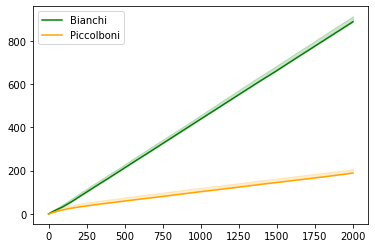

In [8]:
game = games.bandit(False,outcome_distribution)

alg = feedexp3_v2.FeedExp3(  game, horizon, 'Bianchi',)
result1 = evaluate_parallel(n_cores, n_folds, horizon, alg, game)
regret1 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.mean(result1,0) 
std1 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.std(result1,0) 
plt.plot(   regret1 , label = 'Bianchi', color = 'green' )
plt.fill_between( range(horizon) ,  regret1    , regret1 + std1 , color = 'green' , alpha = 0.2)

alg = feedexp3.FeedExp3(  game, horizon, 'Piccolboni',)
result2 = evaluate_parallel(n_cores, n_folds, horizon, alg, game)
regret2 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.mean(result2,0) 
std2 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.std(result2,0) 
plt.plot(   regret2  , label = 'Piccolboni', color = 'orange' )
plt.fill_between( range(horizon) ,  regret2    , regret2 + std2 , color = 'orange' , alpha = 0.2)

plt.legend()


nbCores: 16 nbFolds: 100 Horizon: 2000
nbCores: 16 nbFolds: 100 Horizon: 2000


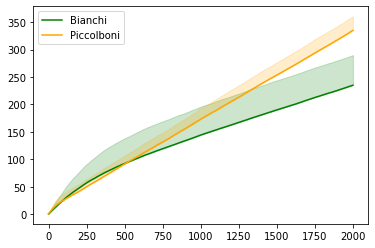

In [9]:
game = games.label_efficient(outcome_distribution)
# import feedexp3_v2
# alg = feedexp3_v2.FeedExp3(  game, horizon, 'Bianchi',)
# task = Evaluation(horizon)
# task.eval_policy_once(alg,game,11)

result1 = evaluate_parallel(n_cores, n_folds, horizon, alg, game)
regret1 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.mean(result1,0) 
std1 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.std(result1,0) 
plt.plot(   regret1 , label = 'Bianchi', color = 'green' )
plt.fill_between( range(horizon) ,  regret1    , regret1 + std1 , color = 'green' , alpha = 0.2)

alg = feedexp3.FeedExp3(  game, horizon, 'Piccolboni',)
result2 = evaluate_parallel(n_cores, n_folds, horizon, alg, game)
regret2 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.mean(result2,0) 
std2 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.std(result2,0) 
plt.plot(   regret2  , label = 'Piccolboni', color = 'orange' )
plt.fill_between( range(horizon) ,  regret2    , regret2 + std2 , color = 'orange' , alpha = 0.2)

plt.legend()
